<a href="https://colab.research.google.com/github/assyifa2/Project_creditrisk/blob/main/PrediksiRisikoKreditTerhadapImbalanceDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data selection**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import cross_val_predict, cross_validate, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, make_scorer, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score,classification_report
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.preprocessing import RobustScaler

In [ ]:
# URL dari dataset dari drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import data dari Gdrive
path='/content/drive/MyDrive/DATASET/german.csv'
german=pd.read_csv(path, sep=' ',header=None)

# **Data Understanding/Preprocessing**

In [ ]:
#mengganti Header nama kolom
german.columns = ["checking_account_status", "duration", "credit_history", "purpose", "credit_amount", "savings", "present_employment", "installment_rate", "personal", "other_debtors",
    "present_residence", "property", "age", "other_installment_plans", "housing", "existing_credits", "job", "dependents", "telephone", "foreign_worker", "customer_type"]

In [ ]:
#buat data frame
df=pd.DataFrame(german)
df.head()

,checking_account_status,duration,credit_history,purpose,credit_amount,savings,present_employment,installment_rate,personal,other_debtors,...,property,age,other_installment_plans,housing,existing_credits,job,dependents,telephone,foreign_worker,customer_type
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   checking_account_status  1000 non-null   object
 1   duration                 1000 non-null   int64 
 2   credit_history           1000 non-null   object
 3   purpose                  1000 non-null   object
 4   credit_amount            1000 non-null   int64 
 5   savings                  1000 non-null   object
 6   present_employment       1000 non-null   object
 7   installment_rate         1000 non-null   int64 
 8   personal                 1000 non-null   object
 9   other_debtors            1000 non-null   object
 10  present_residence        1000 non-null   int64 
 11  property                 1000 non-null   object
 12  age                      1000 non-null   int64 
 13  other_installment_plans  1000 non-null   object
 14  housing                  1000 non-null   

 ### Data memiliki 2 tipe ata yaitu 13 data berisi data kategorikal dan 8 data bertipe numerik

# Target variable:

* customer_type - Integer --> 1 (good), 2 (bad)

# Variabel yang bertipe kategorikal, yaitu:

* checking_account_status:

 A11: ... < 0 DM (Deutsche Mark)-->Ini menunjukkan pemohon memiliki saldo negatif di rekening gironya. Ini adalah tanda bahaya bagi pemberi pinjaman karena menunjukkan pengelolaan keuangan yang buruk.

 A12: 0 <= ... < 200 DM--> Pemohon memiliki rekening giro dengan saldo rendah antara 0 dan 200 Deutschmarks (DM). Hal ini tidak selalu menyiratkan kelayakan kredit yang buruk, tetapi juga tidak menunjukkan bantalan keuangan yang kuat.

 A13: ... >= 200 DM / Salary Assigment for at least 1 year -->Ini adalah opsi yang paling positif. Pemohon memiliki rekening giro dengan saldo minimal 200 DM. Selain itu, mereka memiliki penugasan gaji minimal selama satu tahun, yang berarti sebagian dari gaji mereka secara otomatis disetorkan ke rekening. Hal ini menunjukkan aliran pendapatan yang stabil dan pengelolaan keuangan yang bertanggung jawab.

 A14: No checking account-->Pemohon tidak memiliki rekening giro. Hal ini dapat disebabkan oleh berbagai alasan, dan tidak secara otomatis berarti kredit buruk.

* credit_history:

 A30: No Credits Taken/All Credits Paid Back Duly
 A31: All Credits At This Bank Paid Back Duly
 A32: Existing Credits Paid Back Duly Till Now
 A33: Delay In Paying Off In The Past
 A34: Critical Account/ Other Credits Existing (Not At This Bank)

* purpose:

 A40 : Car (New)
 A41 : Car (Used)
 A42: Furniture/Equipment
 A43: Radio/Television
 A44 : Domestic Appliances
 A45 : Repairs
 A46 : Education
 A47 : (Vacation - Does Not Exist?)
 A48 : Retraining
 A49 : Business
 A410 :Others

* savings:

 A61: … < 100 DM

 A62: 100 <= … < 500 DM

 A63: 500 <=…<1000 DM

 A64: ... >= 1000 DM

 A65: Unknown/ No Saving Account

* present_employment:

 A71: unemployed

 A72: ... < 1 year

 A73: 1 <= ... < 4 years

 A74: 4 <= ... < 7 years

 A75:... >= 7 years

* personal:

 A91 : Male:Divorced/Separated

 A92 : Female:Divorced/Separated/ Married

 A93 : Male:Single

 A94 : Male:Married/Widowed

 A95 : Female:Single


* other_debtors:

 A101 : none

 A102 : co-applicant

 A103 : guarantor

* property:

 A121 : Real Estate

 A122 : If Not A121 : Building Society Savings

 Agreement/ Life Insurance

 A123 : If Not A121/A122 : Car Or Other, Not In

 Attribute 6
 A124 : Unknown / No Property

* other_installment_plans:

 A141:Bank

 A142:Stores

 A143:None

* housing:

 A151 : Rent

 A152 : Own

 A153 : For Free

* job:

 A171 : unemployed/ unskilled  - non-resident

 A172 : unskilled - resident

 A173 : skilled employee / official

 A174 : management/ self-employed/ highly qualified employee/ officer

* telephone:

 A191 : None

 A192 : Yes, Registered Under The Customers Name

* foreign_worker:

 A191 : None

 A192 : Yes, Registered Under The Customers Name


# Variabel bertipe numerik, yaitu:

* duration:

Duration in Month
* credit_amount:

Credit (Loan) Amount
* installment_rate:

 0>10%
 11% > 20 %
 31% > 40%
 41 > 50%

* present_residence:

 1: 0 > 2 year

 2: 3 > 4 year

 3: 5 > 6 years

 4: 7 > … years

* age:

age in years
* existing_credits:

 1: 0 existing credits

 2: 1 existing credits

 3: 2 existing credits

 4: 3 > … existing credits

* dependents:

 1 : yes

 2 : no






In [ ]:
df.describe()

,duration,credit_amount,installment_rate,present_residence,age,existing_credits,dependents,customer_type
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000,1.300000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086,0.458487
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000,2.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,2.000000


In [ ]:
#cek nilai kosong
df.isnull().sum()

checking_account_status    0
duration                   0
credit_history             0
purpose                    0
credit_amount              0
savings                    0
present_employment         0
installment_rate           0
personal                   0
other_debtors              0
present_residence          0
property                   0
age                        0
other_installment_plans    0
housing                    0
existing_credits           0
job                        0
dependents                 0
telephone                  0
foreign_worker             0
customer_type              0
dtype: int64

In [ ]:
df.isna().sum()

checking_account_status    0
duration                   0
credit_history             0
purpose                    0
credit_amount              0
savings                    0
present_employment         0
installment_rate           0
personal                   0
other_debtors              0
present_residence          0
property                   0
age                        0
other_installment_plans    0
housing                    0
existing_credits           0
job                        0
dependents                 0
telephone                  0
foreign_worker             0
customer_type              0
dtype: int64

Data tidak memiliki *null value*

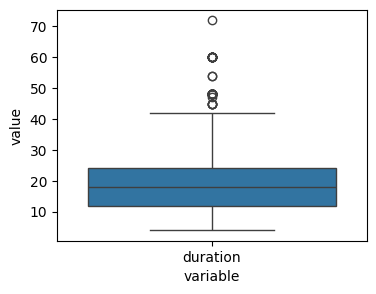

In [ ]:
plt.figure(figsize=(4, 3))
sns.boxplot(x='variable',y='value',data=pd.melt(df[['duration']]))
plt.show()

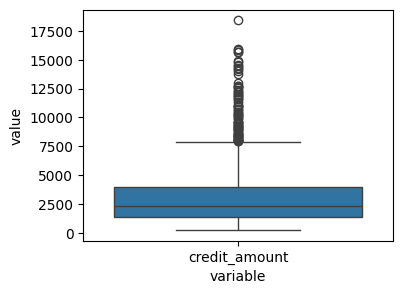

In [ ]:
plt.figure(figsize=(4, 3))
sns.boxplot(x='variable',y='value',data=pd.melt(df[['credit_amount']]))
plt.show()

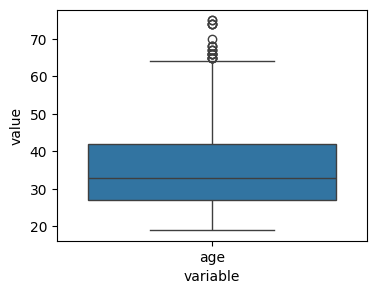

In [ ]:
plt.figure(figsize=(4, 3))
sns.boxplot(x='variable',y='value',data=pd.melt(df[['age']]))
plt.show()

berdasarkan hasil boxplot,ada beberapa outlier pada variabel age(7),credit amount(25) dan duration(14),outlier yang ditampikaan bukan merupakan kesalahan pengukuran atau entri data yang salah, melihat karakteristik random foret yang tahan terhadap outlier,maka data tetap dipertahankan.

In [ ]:
# Praproses data non-numerik
label_encoder = LabelEncoder()
non_numeric_columns = df.select_dtypes(exclude=['number']).columns
for column in non_numeric_columns:
    df[column] = label_encoder.fit_transform(df[column])

meskipun random forest tahan terhadap nilai bertipe kategorikal,pelabelan tetap harus dilakukan karena penggunaan teknik resampling perlu merubah data kategorikal menjadi numerik,karena, dalam praktiknya, penggunaan SMOTE melibatkan data yang terdiri dari variabel numerik karena konsep jarak (Euclidean distance) dalam mencari tetangga terdekat lebih mudah diterapkan pada data numerik.

In [ ]:
from scipy.stats import f_oneway

# Kelompokkan data berdasarkan nilai customer_type
grouped_data = [df[df['customer_type'] == class_name] for class_name in df['customer_type'].unique()]

# Lakukan uji ANOVA untuk setiap fitur
for feature in df.columns:
    if feature != 'customer_type':  # Skip variabel target
        f_statistic, p_value = f_oneway(*[group[feature] for group in grouped_data])
        print(f"Feature: {feature}, F-statistic: {f_statistic}, p-value: {p_value}")


Feature: checking_account_status, F-statistic: 140.0922814512124, p-value: 2.4416618064128288e-30
Feature: duration, F-statistic: 48.333790132789034, p-value: 6.488049877187189e-12
Feature: credit_history, F-statistic: 55.12304460141705, p-value: 2.4230600689647656e-13
Feature: purpose, F-statistic: 0.0022886225138613594, p-value: 0.9618536879893452
Feature: credit_amount, F-statistic: 24.482365876282, p-value: 8.797572373533373e-07
Feature: savings, F-statistic: 33.01357294248414, p-value: 1.2147983456827244e-08
Feature: present_employment, F-statistic: 13.612738944563477, p-value: 0.0002367939320576643
Feature: installment_rate, F-statistic: 5.259417069804217, p-value: 0.022035486306960176
Feature: personal, F-statistic: 7.821743479677289, p-value: 0.005261326205666935
Feature: other_debtors, F-statistic: 0.6309920680537993, p-value: 0.427180494598151
Feature: present_residence, F-statistic: 0.008786500366837886, p-value: 0.9253374212983783
Feature: property, F-statistic: 20.71888286

Analisis F-statistik dan p-value menunjukkan bahwa fitur seperti *credit_history, duration, savings, checking_account_status, purpose, credit_amount, present_employment, installment rate, personal, property, age, other_installment_plans, *dan *foreingn_worker* memiliki hubungan yang kuat dan signifikan dengan kelayakan kredit (customer_credit). Fitur lain seperti *present_residence, other_debtors, housing, existing_credits, job, dependents,* dan *telephone* memiliki hubungan yang lebih lemah

In [ ]:
# Mengganti nilai 1 dengan 0 dan nilai 2 dengan 1 di kolom 'customer_type'
df['customer_type'] = df['customer_type'].replace({1: 0, 2: 1})

In [ ]:
df['customer_type'].value_counts()

customer_type
0    700
1    300
Name: count, dtype: int64

In [ ]:
# Memisahkan fitur dan target
X = df.drop('customer_type', axis=1)
y = df['customer_type']

In [ ]:
# Menerapkan SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

In [ ]:
y_smote.value_counts()

customer_type
0    700
1    700
Name: count, dtype: int64

# ***Modelling(sebelum menggunakan teknik SMOTE)***

In [ ]:
# Inisialisasi model RandomForestClassifier
model = RandomForestClassifier(n_estimators=100)  # Sesuaikan hiperparameter sesuai kebutuhan
model.fit(X, y)

RandomForestClassifier()

In [ ]:
# Inisialisasi RFE dengan model RandomForestClassifier
rfe = RFE(model)

# Melakukan seleksi fitur
X_nonsmote_rfe_selected = rfe.fit_transform(X,y)


In [ ]:
# Menampilkan fitur yang dipilih oleh RFE
selected_features = X.columns[rfe.support_]
print("Fitur yang dipilih oleh RFE:", selected_features)

Fitur yang dipilih oleh RFE: Index(['checking_account_status', 'duration', 'credit_history', 'purpose',
       'credit_amount', 'savings', 'present_employment', 'present_residence',
       'property', 'age'],
      dtype='object')


# ***Evaluation (sebelum menggunakan teknik SMOTE)***

In [ ]:
# Melakukan cross-validation
# Cross-validation
kfold = KFold(n_splits=10)
results = cross_validate(estimator=model,
                         X=X_nonsmote_rfe_selected,
                         y=y,
                         cv=kfold)

In [ ]:
# Memprediksi target
y_pred = cross_val_predict(model, X_nonsmote_rfe_selected, y, cv=10)

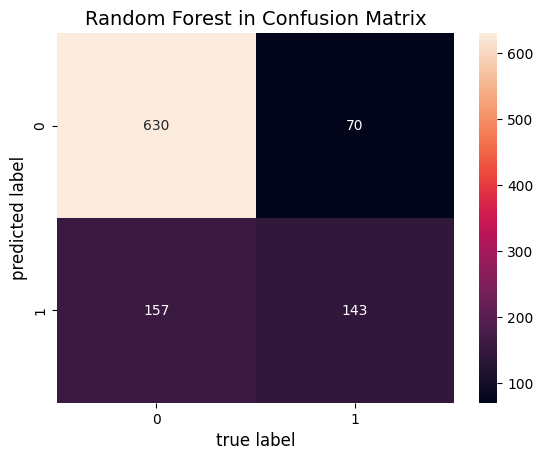

In [ ]:
# Confusion matrix
conf_mat = confusion_matrix(y, y_pred)
sns.heatmap(conf_mat, annot=True, fmt="d")
plt.title('Random Forest in Confusion Matrix', fontsize=14)
plt.xlabel('true label', fontsize=12)
plt.ylabel('predicted label', fontsize=12)
plt.show()

In [ ]:
# Menghitung TP, TN, FP, FN
TP = conf_mat[1, 1]
TN = conf_mat[0, 0]
FP = conf_mat[0, 1]
FN = conf_mat[1, 0]
# Menampilkan TP, TN, FP, FN
print("True Positives (TP):", TP)
print("True Negatives (TN):", TN)
print("False Positives (FP):", FP)
print("False Negatives (FN):", FN)

True Positives (TP): 143
True Negatives (TN): 630
False Positives (FP): 70
False Negatives (FN): 157


In [ ]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85       700
           1       0.67      0.48      0.56       300

    accuracy                           0.77      1000
   macro avg       0.74      0.69      0.70      1000
weighted avg       0.76      0.77      0.76      1000



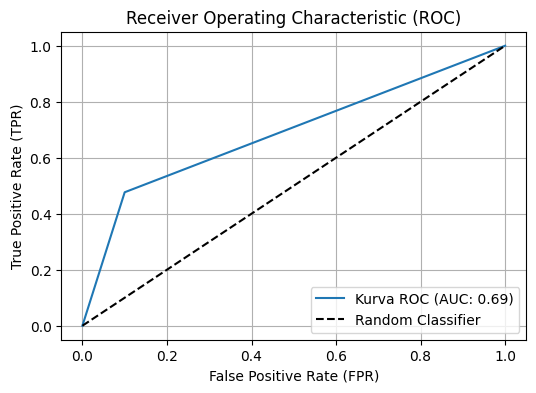

In [ ]:
# Visualisasi Kurva ROC
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y, y_pred)
auc_value = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label='Kurva ROC (AUC: {:.2f})'.format(auc_value))
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# ***Modelling(setelah menggunakan teknik SMOTE)***

In [ ]:
# Inisialisasi model RandomForestClassifier
model2 = RandomForestClassifier(n_estimators=100)  # Sesuaikan hiperparameter sesuai kebutuhan
model2.fit(X_smote, y_smote)

RandomForestClassifier()

In [ ]:
# Inisialisasi RFE dengan model RandomForestClassifier
rfe2 = RFE(model2)

# Melakukan seleksi fitur
X_smote_rfe_selected = rfe2.fit_transform(X_smote, y_smote)

In [ ]:
# Menampilkan fitur yang dipilih oleh RFE
selected_features = X.columns[rfe2.support_]
print("Fitur yang dipilih oleh RFE:", selected_features)

Fitur yang dipilih oleh RFE: Index(['checking_account_status', 'duration', 'credit_history', 'purpose',
       'credit_amount', 'savings', 'present_employment', 'personal',
       'present_residence', 'age'],
      dtype='object')


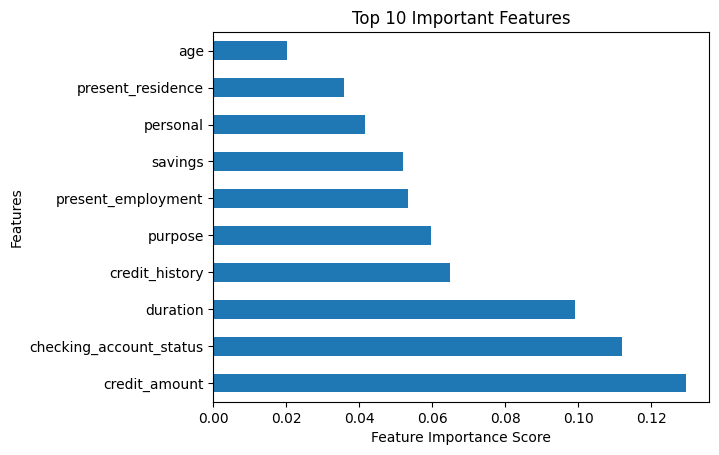

In [ ]:
# Mendapatkan feature importances dari fitur yang dipilih oleh RFE
feat_importances = pd.Series(model.feature_importances_[:len(selected_features)], index=selected_features)

# Memvisualisasikan 10 fitur terpenting
feat_importances.nlargest(10).plot(kind='barh')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Top 10 Important Features')
plt.show()

berdasarkan hasil uji dengan model random forest,hasil seleksi fitur RFE cukup signifikan dengan uji annova

# ***Evaluation(setelah menggunakan teknik SMOTE)***

In [ ]:
# Melakukan cross-validation
# Cross-validation
kfold2 = KFold(n_splits=10)
results2 = cross_validate(estimator=model2,
                         X=X_smote_rfe_selected,
                         y=y_smote,
                         cv=kfold2)

In [ ]:
# Memprediksi target
y_pred2 = cross_val_predict(model2, X_smote_rfe_selected, y_smote)

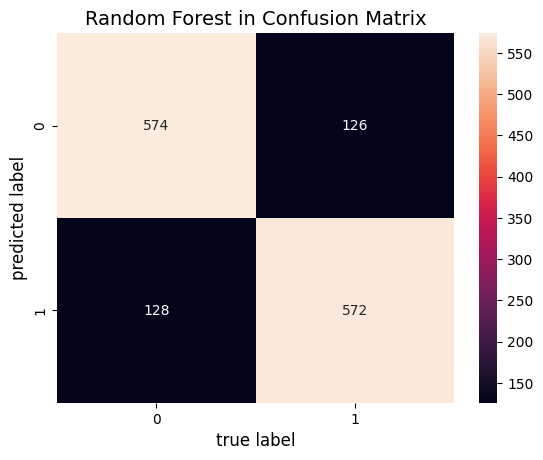

In [ ]:
# Confusion matrix
conf_mat2 = confusion_matrix(y_smote, y_pred2)
sns.heatmap(conf_mat2, annot=True, fmt="d")
plt.title('Random Forest in Confusion Matrix', fontsize=14)
plt.xlabel('true label', fontsize=12)
plt.ylabel('predicted label', fontsize=12)
plt.show()

In [ ]:
# Menghitung TP, TN, FP, FN
TP = conf_mat2[1, 1]
TN = conf_mat2[0, 0]
FP = conf_mat2[0, 1]
FN = conf_mat2[1, 0]
# Menampilkan TP, TN, FP, FN
print("True Positives (TP):", TP)
print("True Negatives (TN):", TN)
print("False Positives (FP):", FP)
print("False Negatives (FN):", FN)

True Positives (TP): 572
True Negatives (TN): 574
False Positives (FP): 126
False Negatives (FN): 128


In [ ]:
print(classification_report(y_smote, y_pred2))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82       700
           1       0.82      0.82      0.82       700

    accuracy                           0.82      1400
   macro avg       0.82      0.82      0.82      1400
weighted avg       0.82      0.82      0.82      1400



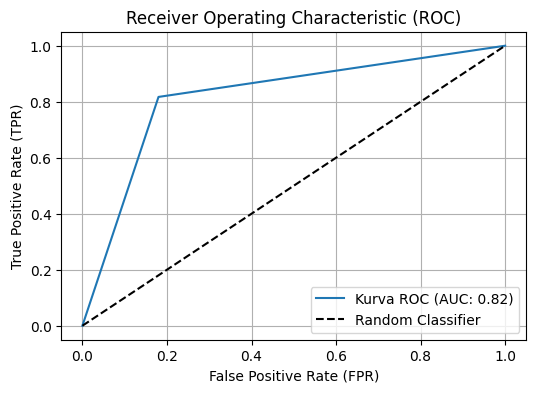

In [ ]:
fpr, tpr, thresholds = roc_curve(y_smote, y_pred2)
auc_value2 = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label='Kurva ROC (AUC: {:.2f})'.format(auc_value2))
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
# Menggabungkan data fitur, target sebenarnya, dan prediksi model
result_df = pd.DataFrame(X_smote, columns=X.columns)
result_df['actual'] = y_smote
result_df['predicted'] = y_pred2

In [ ]:
# Menampilkan data yang sebenarnya positif tetapi diprediksi sebagai negatif
false_negatives = result_df[(result_df['actual'] == 1) & (result_df['predicted'] == 0)]
print("Jumlah false negatives:", len(false_negatives))
false_negatives.head()

Jumlah false negatives: 128


,checking_account_status,duration,credit_history,purpose,credit_amount,savings,present_employment,installment_rate,personal,other_debtors,...,age,other_installment_plans,housing,existing_credits,job,dependents,telephone,foreign_worker,actual,predicted
13,0,24,4,0,1199,0,4,4,2,0,...,60,2,1,2,1,1,0,0,1,0
54,1,36,3,0,2225,0,4,4,2,0,...,57,0,2,2,2,1,1,0,1,0
56,1,12,2,4,6468,4,0,2,2,0,...,52,2,1,1,3,1,1,0,1,0
68,3,36,2,7,1819,0,2,4,2,0,...,37,1,2,1,2,1,1,0,1,0
74,0,36,2,7,1977,4,4,4,2,0,...,40,2,1,1,3,1,1,0,1,0


In [ ]:
# Membuat DataFrame dengan data fitur
result_df = pd.DataFrame(X_smote, columns=X.columns)

# Menambahkan kolom untuk target sebenarnya dan prediksi model
result_df['actual'] = y_smote
result_df['predicted'] = y_pred2

# Menyimpan DataFrame ke dalam file Excel
result_df.to_excel('result_dataset.xlsx', index=False)

# Mengunduh file Excel
from google.colab import files
#files.download('result_dataset.xlsx')

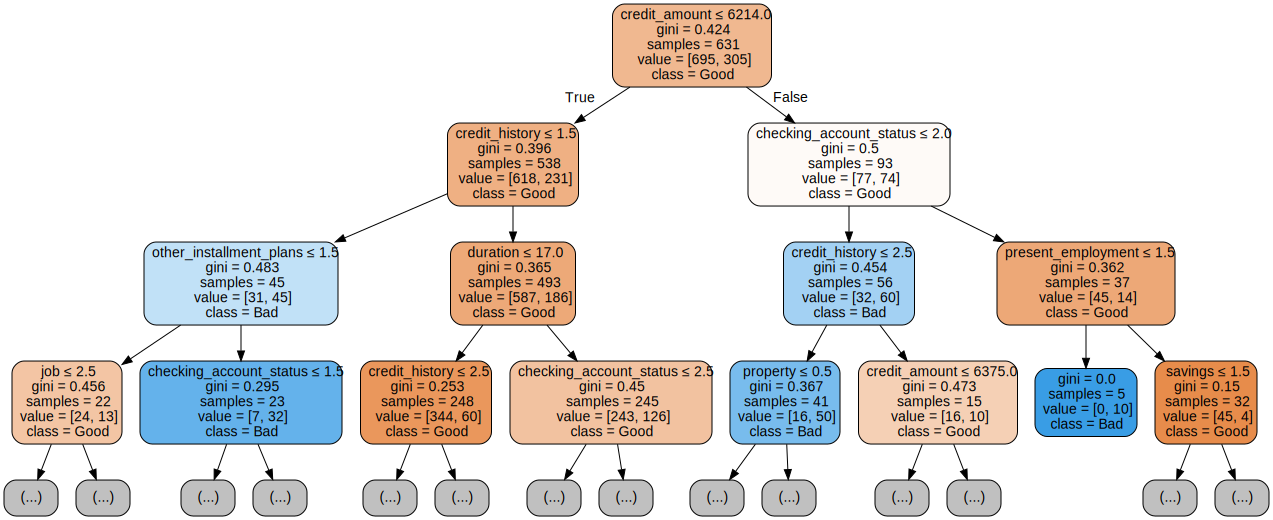

In [ ]:
from sklearn.tree import export_graphviz
import graphviz
from google.colab import files

# Mengekstrak salah satu pohon dari model RandomForest
tree = model.estimators_[0]

# Batasi kedalaman pohon
max_depth = 3

# Visualisasi pohon keputusan
dot_data = export_graphviz(tree, out_file=None,
                           feature_names=X.columns,
                           class_names=['Good', 'Bad'],
                           filled=True, rounded=True,
                           special_characters=True,
                           max_depth=max_depth)

# Membuat objek graphviz
graph = graphviz.Source(dot_data)

# Menyimpan visualisasi dalam format .pdf dan .png
graph.render("random_forest_tree_small", format='png') # Menyimpan dalam format PNG


#files.download("random_forest_tree_small.png")
graph

In [ ]:
files.download("random_forest_tree.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>